In [1]:
import pandas as pd
from pycaret.classification import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# 데이터 로딩
match_data = pd.read_csv('/Users/lhe339/Documents/GitHub/nextorial/data/데이터 분석가_과제_Type A/match_data.csv')
test_data = pd.read_csv('/Users/lhe339/Documents/GitHub/nextorial/data/데이터 분석가_과제_Type A/test_data.csv')

In [3]:
class DataProcessor:
    
    def __init__(self, df):
        self.data = df

    @staticmethod
    def convert_tier_to_numeric(tier):
        tier_dict = {
            'unranked': 0,
            'bronze': 1,
            'silver': 2,
            'gold': 3,
            'platinum': 4,
            'diamond': 5,
            'master': 6
        }
        return tier_dict.get(tier, -1)

    # guild_membership
    def guild_avg(self):
        df = self.data.copy()
        df['guildid'].fillna('NoGuild', inplace=True)
        df['tier_numeric'] = df['tier'].map(self.convert_tier_to_numeric)
        guild_avg = df.groupby('guildid')[['mmr', 'winstreak', 'recentwinprob', 'accumatches', 'tier_numeric']].mean()
        new_columns = {col: f'{col}_guild_avg' for col in guild_avg.columns}
        guild_avg.rename(columns=new_columns, inplace=True)
        df = pd.merge(df, guild_avg, on='guildid', how='left')
        return df
    
    
    # high_mmr_guild
    def process_guild_info(self, threshold):
        guild_mean_mmr = self.data.groupby('guildid')['mmr'].mean()
        self.data['guild_mean_mmr'] = self.data['guildid'].map(guild_mean_mmr)
        self.data['high_mmr_guild'] = (self.data['guild_mean_mmr'] > threshold).astype(int)
        return self.data    
    
    def preprocess(self):
        self.data = self.guild_avg()
        self.data = self.process_guild_info(2000)



In [4]:
processor = DataProcessor(match_data)
processor.preprocess()
processed_data = processor.data

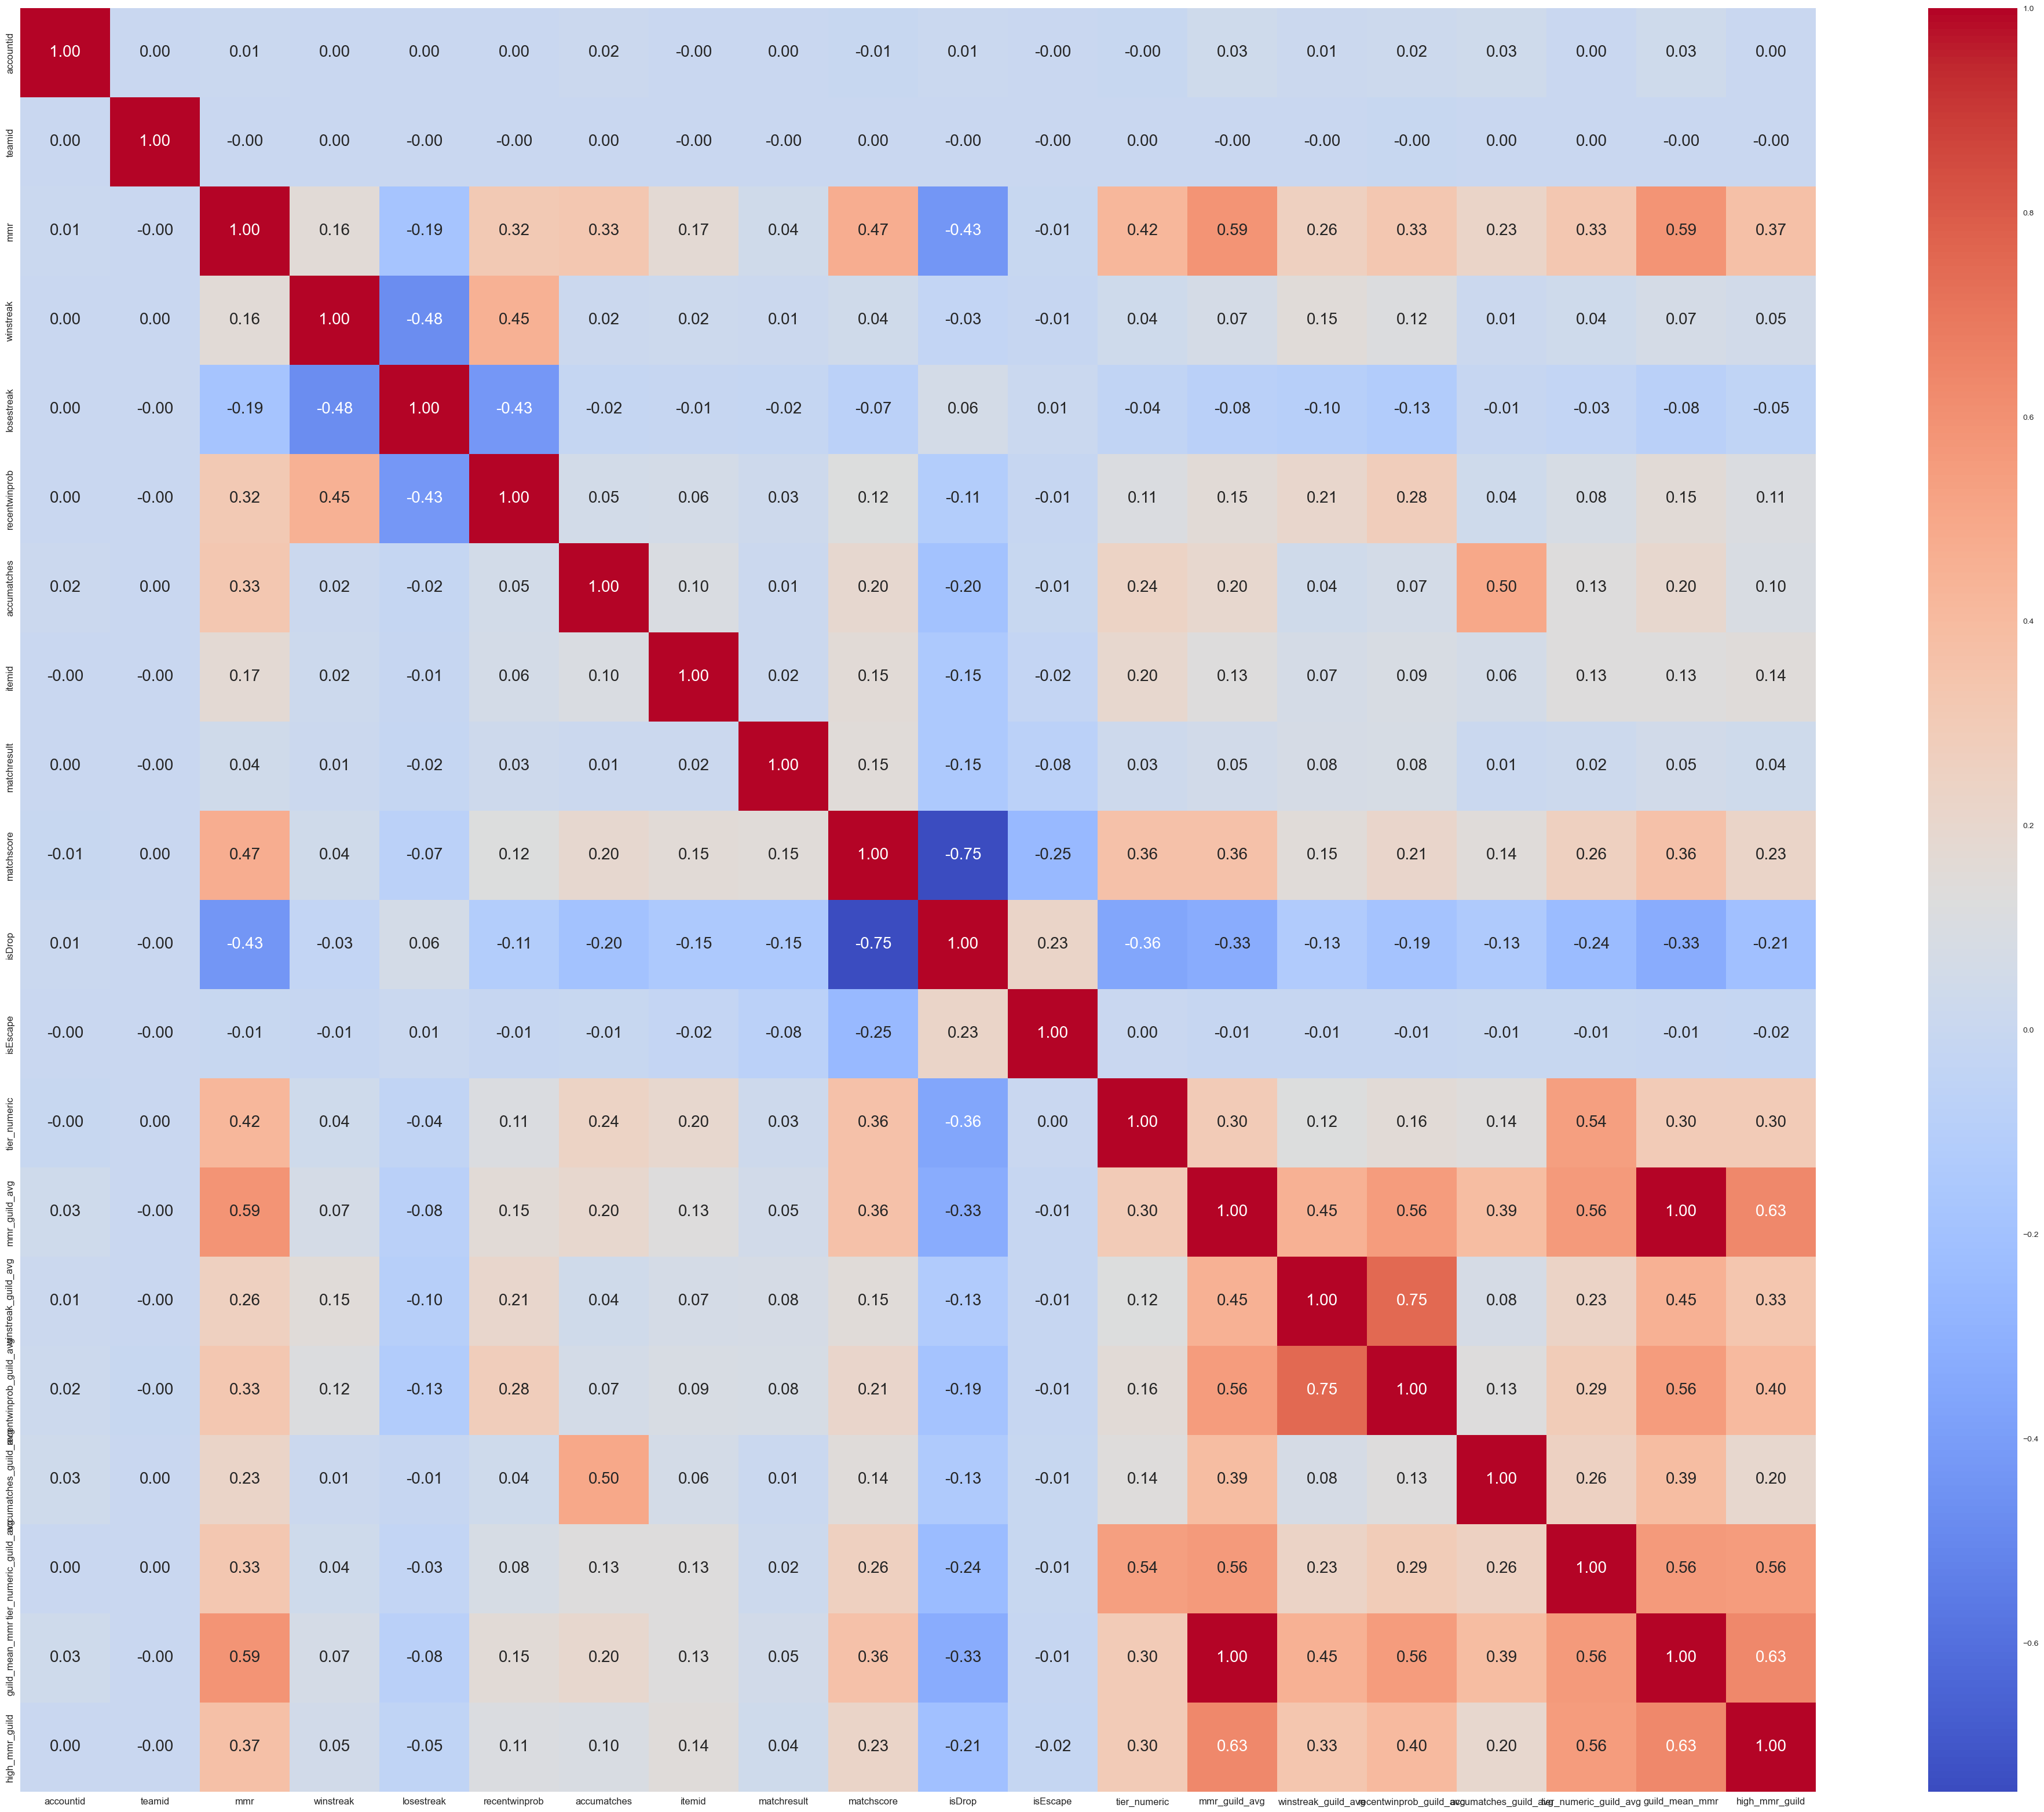

In [5]:
# 문자열 데이터를 포함하는 열을 제거
numeric_data = processed_data.select_dtypes(include=[np.number])

# 상관 행렬 계산
corr_matrix = numeric_data.corr()

plt.figure(figsize=(50, 40))

# 히트맵 표시
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={'size': 20})

# x와 y축의 레이블에 대한 글꼴 크기 조정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [ ]:
# PyCaret 설정
clf1 = setup(data = match_data,
             target = 'matchresult',
             use_gpu = True,
             ignore_features = ['createdatekst', 'matchid', 'accountid', 'guildid'],  # 무시할 특성
             ordinal_features = {'tier': ['unranked', 'bronze', 'silver', 'gold', 'platinum', 'diamond', 'master']},  # 순서형 특성
             session_id=123)  # 재현 가능성을 위한 세션 ID 설정

In [ ]:
# 모델 비교
compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:18:57
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.5722,0.6063,0.6429,0.5633,0.6005,0.1444,0.1459,35.6650
ada,Ada Boost Classifier,0.5702,0.6028,0.6186,0.5640,0.5900,0.1404,0.1411,9.3670
ridge,Ridge Classifier,0.5620,0.0000,0.7084,0.5479,0.6179,0.1239,0.1296,0.5500
lda,Linear Discriminant Analysis,0.5619,0.5923,0.7084,0.5479,0.6179,0.1239,0.1296,1.7650
lr,Logistic Regression,0.5577,0.5893,0.6415,0.5494,0.5916,0.1153,0.1172,1.4890
nb,Naive Bayes,0.5541,0.5667,0.8023,0.5361,0.6427,0.1081,0.1245,0.4110
rf,Random Forest Classifier,0.5492,0.5728,0.5577,0.5484,0.5530,0.0985,0.0985,20.2490
qda,Quadratic Discriminant Analysis,0.5415,0.5634,0.7950,0.5286,0.6308,0.0829,0.1000,1.8310
knn,K Neighbors Classifier,0.5258,0.5342,0.5273,0.5258,0.5265,0.0517,0.0517,22.9400
dt,Decision Tree Classifier,0.5215,0.5214,0.5202,0.5215,0.5209,0.0429,0.0429,1.1580


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [3]:
class DataProcessor:
    
    def __init__(self, df):
        self.data = df

    @staticmethod
    def convert_tier_to_numeric(tier):
        tier_dict = {
            'unranked': 0,
            'bronze': 1,
            'silver': 2,
            'gold': 3,
            'platinum': 4,
            'diamond': 5,
            'master': 6
        }
        return tier_dict.get(tier, -1)

    # guild_membership
    def guild_mean(self):
        df = self.data.copy()
        df['guildid'].fillna('NoGuild', inplace=True)
        df['tier_numeric'] = df['tier'].map(self.convert_tier_to_numeric)
        guild_mean = df.groupby('guildid')[['mmr', 'winstreak', 'recentwinprob', 'accumatches', 'tier_numeric']].mean()
        new_columns = {col: f'{col}guild_mean' for col in guild_mean.columns}
        guild_mean.rename(columns=new_columns, inplace=True)
        df = pd.merge(df, guild_mean, on='guildid', how='left')
        return df
    
    def guild_median(self):
        df = self.data.copy()
        df['guildid'].fillna('NoGuild', inplace=True)
        df['tier_numeric'] = df['tier'].map(self.convert_tier_to_numeric)
        guild_median = df.groupby('guildid')[['mmr', 'winstreak', 'recentwinprob', 'accumatches', 'tier_numeric']].median()
        new_columns = {col: f'{col}guild_median' for col in guild_median.columns}
        guild_median.rename(columns=new_columns, inplace=True)
        df = pd.merge(df, guild_median, on='guildid', how='left')
        return df
    
    def guild_mode(self):
        df = self.data.copy()
        df['guildid'].fillna('NoGuild', inplace=True)
        df['tier_numeric'] = df['tier'].map(self.convert_tier_to_numeric)
        
        def calculate_mode(group):
            return group.mode().iloc[0]
        
        guild_mode = df.groupby('guildid')[['mmr', 'winstreak', 'recentwinprob', 'accumatches', 'tier_numeric']].apply(calculate_mode)
        new_columns = {col: f'{col}guild_mode' for col in guild_mode.columns}
        guild_mode.rename(columns=new_columns, inplace=True)
        df = pd.merge(df, guild_mode, on='guildid', how='left')
        return df

    
    # high_mmr_guild
    def process_guild_info(self, threshold):
        guild_mean_mmr = self.data.groupby('guildid')['mmr'].mean()
        self.data['guild_mean_mmr'] = self.data['guildid'].map(guild_mean_mmr)
        self.data['high_mmr_guild'] = (self.data['guild_mean_mmr'] > threshold).astype(int)
        return self.data    
    
    def preprocess(self):
        self.data = self.guild_mean()
        self.data = self.guild_median()
        self.data = self.guild_mode()
        self.data = self.process_guild_info(2000)




In [4]:
processor = DataProcessor(match_data)
processor.preprocess()
processed_data = processor.data

AttributeError: 'DataFrameGroupBy' object has no attribute 'mode'